# Notebook for project development
*By: Patcharanat Pattanaporn*

Table of contents
1. Import Library
2. Define Function
    - Code in [`ee_functions.py`](ee_functions.py)
3. Load Data
    - Select a floor and union table
    - Separate zone and choose one
    - Reduce Data resolution
4. Data Pre-processing
    - Imputation techniques
    - Sum features
    - Date feature and rolling feature engineering
    - Specify Input and Output
    - Scaling and Splitting data
5. Model Development
    - Cross validation and Tune Model
    - Baseline model
    - DecisionTree
    - RandomForestRegressor
    - SVM
        - LinearSVR
        - SVR (poly, rbf)
    - GBM (scikit-learn)
    - HistGBM
    - AdaBoost
    - XGBoost
    - CatBoost
    - LightGBM
6. Model Evaluation
    - Visualize result
    - Model Performance
    - Imputation Performance
    - Affect of outlier

**Read [`README.md`](README.md) to get the full explanation**

*Disclaimer: This notebook excludes explaination.*

---

## 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import time
import copy

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from verstack import NaNImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit

# from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')

# some necessary libraries imported in ee_functions.py file

---

## 2. Define Function

In [2]:
import ee_functions as ee

---

## 3. Load Data

In [4]:
df = ee.make_data_sample(floor=4)
init_zone = ee.sep_zone(df)
print(init_zone.keys())

dict_keys(['z1', 'z2', 'z3', 'z4', 'z5'])


In [5]:
# specify zone needed here
zone, cols_name = ee.choose_zone(init_zone, ['z1'])

df = df[cols_name]
df = ee.reduce_resolution(df, interval=15)
print(df.shape)
df.head()

(52704, 10)


,Date,z1_AC1(kW),z1_AC2(kW),z1_AC3(kW),z1_AC4(kW),z1_Light(kW),z1_Plug(kW),z1_S1(degC),z1_S1(RH%),z1_S1(lux)
0,2018-07-01 00:00:00,0.0,0.0,0.0,8.742667,0.002000,0.224000,28.289333,62.504000,0.0
1,2018-07-01 00:15:00,0.0,0.0,0.0,8.774667,0.002000,0.224667,28.293333,62.448000,0.0
2,2018-07-01 00:30:00,0.0,0.0,0.0,8.773333,0.002857,0.238667,28.297333,62.356000,0.0
3,2018-07-01 00:45:00,0.0,0.0,0.0,8.765333,0.003333,0.226000,28.288667,62.347333,0.0
4,2018-07-01 01:00:00,0.0,0.0,0.0,8.792667,0.002667,0.226667,28.296667,62.345333,0.0


---

## 4. Data Pre-processing

### Impute Missing Values

Impute missing value by using Iterative Imputer (Multivariate Imputation) for each zone without timeseries features.

In [227]:
imputer_iterative_transformer = FunctionTransformer(ee.imputer_iterative, kw_args={'zone': zone})
df_sample = imputer_iterative_transformer.fit_transform(df)

using KNN Imputer

In [180]:
# imputer_knn_transformer = FunctionTransformer(ee.imputer_knn, kw_args={'zone': zone})

In [181]:
# df_sample = imputer_knn_transformer.fit_transform(df)

using mean and groupby for imputation

In [ ]:
# imputer_meangroupby_transformer = FunctionTransformer(ee.imputer_meangroupby)
# df_sample = imputer_meangroupby_transformer.fit_transform(df)

NaNImputer using LightGBM for imputation from verstack 

In [ ]:
# imputer_nan = NaNImputer(train_sample_size=df.shape[0], verbose=True)
# df_sample = imputer_nan.impute(df)
# df_sample = ee.process_data(df_sample)

### Split Data 

In [3]:
# save imputed dataframe
# df_sample.to_parquet('./data_sample/df_sample5.parquet')
# df_sample.to_parquet('./data_sample/df_sample10.parquet')
# df_sample.to_parquet('./data_sample/df_sample15.parquet')
# df_sample.to_parquet('./data_sample/df_sample30.parquet')

# load imputed dataframe
# df_sample = pd.read_parquet('./data_sample/df_sample5.parquet')
# df_sample = pd.read_parquet('./data_sample/df_sample10.parquet')
df_sample = pd.read_parquet('./data_sample/df_sample15.parquet')
# df_sample = pd.read_parquet('./data_sample/df_sample30.parquet')
print("DataFrame Shape:", df_sample.shape)
df_sample.head()

DataFrame Shape: (52704, 19)


,Date,z1_S1(degC),z1_S1(RH%),z1_S1(lux),sum_ac(kW),sum_light(kW),sum_plug(kW),sum_power_consumption(kW),SMA30,SMA15,SMA7,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2018-07-01 00:00:00,28.289333,62.504000,0.0,8.742667,0.002000,0.224000,8.968667,8.968667,8.968667,8.968667,0,6,3,7,2018,182,1,26
1,2018-07-01 00:15:00,28.293333,62.448000,0.0,8.774667,0.002000,0.224667,9.001333,8.985000,8.985000,8.985000,0,6,3,7,2018,182,1,26
2,2018-07-01 00:30:00,28.297333,62.356000,0.0,8.773333,0.002857,0.238667,9.014857,8.994952,8.994952,8.994952,0,6,3,7,2018,182,1,26
3,2018-07-01 00:45:00,28.288667,62.347333,0.0,8.765333,0.003333,0.226000,8.994667,8.994881,8.994881,8.994881,0,6,3,7,2018,182,1,26
4,2018-07-01 01:00:00,28.296667,62.345333,0.0,8.792667,0.002667,0.226667,9.022000,9.000305,9.000305,9.000305,1,6,3,7,2018,182,1,26


In [84]:
X, y = ee.sep_input_output(df_sample)
X_train, X_test, y_train, y_test = ee.train_test_split_data(X, y, train_size=0.8)

In [10]:
X_train_new, X_eval, y_train_new, y_eval = ee.train_test_split_data(ee.set_index_as_index(X_train), ee.set_index_as_index(y_train), train_size=0.8)

### Scaling

In [249]:
y_test_not_scaled = y_test.copy()

In [5]:
# Fit scaler on input data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# # Fit scaler on output data
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [180]:
# scaling validation set
scaler_X_eval = StandardScaler()
X_train_new = scaler_X_eval.fit_transform(X_train_new)
X_eval = scaler_X_eval.transform(X_eval)

scaler_y_eval = StandardScaler()
y_train_new = scaler_y_eval.fit_transform(y_train_new)
y_eval = scaler_y_eval.transform(y_eval)

---

<AxesSubplot:>

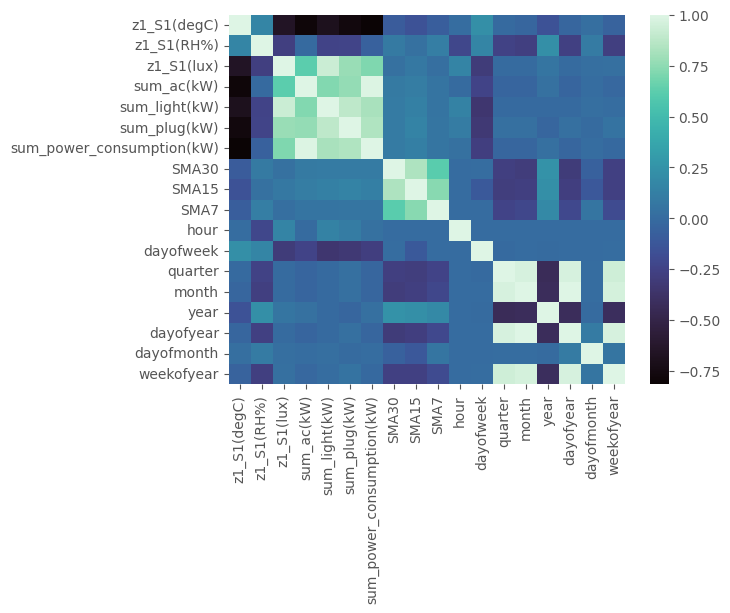

In [234]:
sns.heatmap(df_sample.corr(method='pearson'), cmap='mako')

<AxesSubplot:>

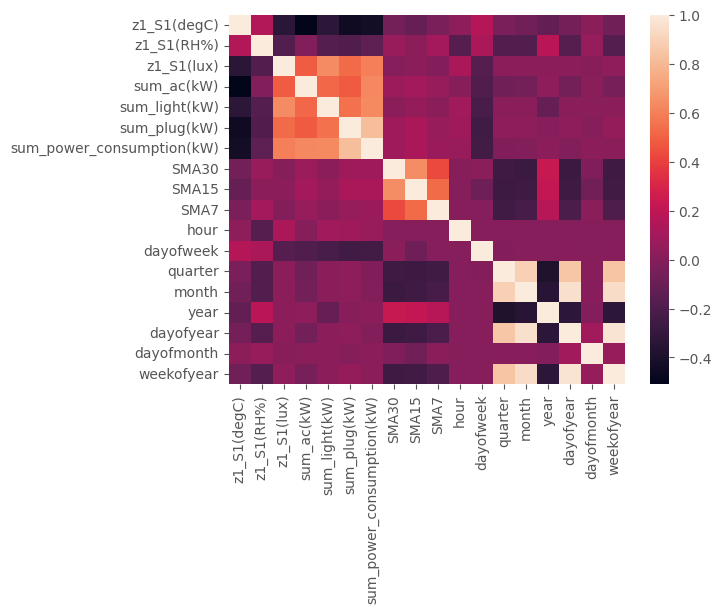

In [235]:
sns.heatmap(df_sample.corr(method='kendall'))

## 5. Model Development

In [14]:
# cross-validation time series-based
tscv = TimeSeriesSplit(n_splits=5)

### A baseline model

In [257]:
baseline_prediction = np.zeros((y_test.shape[0], 4))
baseline_prediction[:, 0] = np.mean(df_sample['sum_ac(kW)'])
baseline_prediction[:, 1] = np.mean(df_sample['sum_light(kW)'])
baseline_prediction[:, 2] = np.mean(df_sample['sum_plug(kW)'])
baseline_prediction[:, 3] = np.mean(df_sample['sum_power_consumption(kW)'])

### Tree-based model

Decision Tree

In [ ]:
model_DT = DecisionTreeRegressor()

params_dist = {
    'criterion': ["squared_error"],
    'splitter': ['best', 'random'],
    'max_depth': [i for i in range(2, 10)],
    'min_samples_leaf': [1, 4, 8, 16, 32],
    'max_features': ['sqrt', None, 0.2, 0.3, 0.4, 0.5, 0.8],
    'random_state': [0]
}

search = HalvingRandomSearchCV(
    estimator=model_DT,
    param_distributions=params_dist,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=0)

init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_DT_tuned = search.best_estimator_
print(search.best_params_)

# save model by joblib
joblib.dump(model_DT_tuned, './model/model_DT_tuned.joblib')

In [ ]:
model_DT_tuned = joblib.load('./model/model_DT_tuned.joblib')

In [ ]:
# prediction_DT = model_DT_tuned.predict(X_test)
# prediction_DT_train = model_DT_tuned.predict(X_train)

# prediction_DT = scaler_y.inverse_transform(prediction_DT)
# prediction_DT_train = scaler_y.inverse_transform(prediction_DT_train)

RandomForest

Implement RandomizedSearchCV and HalvingRandomizedSearchCV

In [ ]:
model_RF = RandomForestRegressor()

params_dist = {
    'n_estimators': [100, 200, 300, 500],
    'criterion': ['squared_error'],
    'min_samples_leaf': [1, 4, 8, 16, 32, 128],
    'max_features': ['sqrt', None, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9],
    'bootstrap': [True],
    'oob_score': [True],
    'random_state': [0]
}

In [ ]:
search = HalvingRandomSearchCV(estimator=model_RF, 
                            param_distributions=params_dist,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            random_state=0)
init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_RF_tuned = search.best_estimator_
print(search.best_params_)

# save model by joblib
print(f'OOB scores: %.04f' % model_RF_tuned.oob_score_)
joblib.dump(model_RF_tuned, './model/model_RF_tuned.joblib')

In [ ]:
model_RF_tuned = joblib.load("./model/model_RF_tuned.joblib")

In [ ]:
# prediction_RF = model_RF_tuned.predict(X_test)
# prediction_RF_train = model_RF_tuned.predict(X_train)

# prediction_RF = scaler_y.inverse_transform(prediction_RF)
# prediction_RF_train = scaler_y.inverse_transform(prediction_RF_train)

### SVM

LinearSVR (much faster than SVR with linear kernel)

In [ ]:
model = MultiOutputRegressor(LinearSVR())

params_dist = [{
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__tol': [1e-3, 1e-4, 1e-5],
    'estimator__loss': ['epsilon_insensitive'],
    'estimator__random_state': [0]
}]

search = HalvingRandomSearchCV(estimator=model,
                              param_distributions=params_dist,
                              cv=tscv,
                              scoring='neg_mean_squared_error',
                              verbose=1,
                              random_state=0)

init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
linear_svr_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = './model/model_linear_svr_tuned.pickle'
pickle.dump(linear_svr_tuned, open(filename, 'wb'))

In [ ]:
linear_svr_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# prediction_linear_svr = linear_svr_tuned.predict(X_test)
# prediction_linear_svr_train = linear_svr_tuned.predict(X_train)

# prediction_svr = scaler_y.inverse_transform(prediction_linear_svr)
# prediction_svr_train = scaler_y.inverse_transform(prediction_linear_svr_train)

SVR with variant kernel

In [ ]:
model_svr = MultiOutputRegressor(SVR())

params_dist = [{
    'estimator__kernel': ['poly', 'rbf'],
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [1, 0.1, 0.01, 0.001],
}]

search = HalvingRandomSearchCV(estimator=model_svr,
                               param_distributions=params_dist,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               random_state=0)
init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_svr_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = './model/model_svr_tuned.pickle'
pickle.dump(model_svr_tuned, open(filename, 'wb'))

In [ ]:
model_svr_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# prediction_svr = model_svr_tuned.predict(X_test)
# prediction_svr_train = model_svr_tuned.predict(X_train)

# prediction_svr = scaler_y.inverse_transform(prediction_svr)
# prediction_svr_train = scaler_y.inverse_transform(prediction_svr_train)

### Gradient Boosting Model

GBM

In [ ]:
model_gbm = MultiOutputRegressor(GradientBoostingRegressor(n_iter_no_change=5, 
                                                           tol=0.001, 
                                                           validation_fraction=0.2, 
                                                           random_state=0))
params_dist = [{"estimator__learning_rate": [0.05, 0.1, 0.3],
                "estimator__n_estimators": [100, 300, 500],
                "estimator__subsample": [0.2, 0.3, 0.4, 0.5],
                "estimator__max_depth": [3, 5, 7, 9],
                "estimator__min_samples_split": [2, 5, 10, 20, int(0.1*df_sample.shape[0])],
                "estimator__min_samples_leaf": [1, 4, 8, int(0.05*df_sample.shape[0])],
                "estimator__criterion": ['friedman_mse', 'squared_error'],
                "estimator__max_features": [0.5, 0.7, 'auto', 'sqrt', 'log2'],
                "estimator__max_leaf_nodes": [4, 6, 8]}]

search = HalvingRandomSearchCV(estimator=model_gbm,
                            param_distributions=params_dist,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            verbose=1,
                            random_state=0)

init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_gbm_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = "./model/model_GBM_tuned.pickle"
pickle.dump(model_gbm_tuned, open(filename, 'wb'))

In [ ]:
model_gbm_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# prediction_gbm_tuned = model_gbm_tuned.predict(X_test)
# prediction_gbm_tuned_train = model_gbm_tuned.predict(X_train)

# prediction_gbm_tuned = scaler_y.inverse_transform(prediction_gbm_tuned)
# prediction_gbm_tuned_train = scaler_y.inverse_transform(prediction_gbm_tuned_train)

HistGBM - *(LightGBM by scikit-learn)*

In [ ]:
model_histgbm = MultiOutputRegressor(HistGradientBoostingRegressor(loss='squared_error',
                                                                   early_stopping=True,
                                                                   random_state=0,))
params_dist = [{
    'estimator__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3],
    'estimator__max_iter': [100, 200, 300, 500],
    'estimator__max_leaf_nodes': [10, 20, 30, 50, 100],
    'estimator__min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'estimator__l2_regularization': [0, 0.3, 0.5, 0.7, 1],
    'estimator__validation_fraction': [0.1, 0.2, 0.3],
    'estimator__n_iter_no_change': [5, 10, 15, 20],
    'estimator__tol': [1e-7, 1e-4, 1e-3, 1e-2]
}]

search = HalvingRandomSearchCV(estimator=model_histgbm,
                               param_distributions=params_dist,
                               cv=tscv,
                               verbose=1,
                               random_state=0)

init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
print(round(end_tune_time/(60), 2), 'mins')
model_histgbm_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = "./model/model_histgbm_tuned.pickle"
pickle.dump(model_histgbm_tuned, open(filename, 'wb'))

In [ ]:
model_histgbm_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# prediction_histgbm = model_histgbm_tuned.predict(X_test)
# prediction_histgbm_train = model_histgbm_tuned.predict(X_train)

# prediction_histgbm = scaler_y.inverse_transform(prediction_histgbm)
# prediction_histgbm_train = scaler_y.inverse_transform(prediction_histgbm_train)

Adaboost

In [ ]:
# # AdaBoost default parameters
# model_adaboost = MultiOutputRegressor(AdaBoostRegressor())

# model_adaboost.fit(X_train, y_train)
# prediction_adaboost = model_adaboost.predict(X_test)
# prediction_adaboost_train = model_adaboost.predict(X_train)

In [ ]:
# tuning ada
model_adaboost = MultiOutputRegressor(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))
params_dist = [{"estimator__n_estimators": [10, 50, 100, 300, 500],
                "estimator__learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5, 1, 2, 3, 5],
                "estimator__base_estimator__max_depth": [1, 2, 3, 4, 5, 7, 8, 9]}]

search = HalvingRandomSearchCV(estimator=model_adaboost,
                            param_distributions=params_dist,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            random_state=0)

init_tune_time = time.time()
search.fit(X_train, y_train)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_adaboost_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = "./model/model_adaboost_tuned.pickle"
pickle.dump(model_adaboost_tuned, open(filename, 'wb'))

In [ ]:
# load model
model_adaboost_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# prediction_adaboost_tuned = model_adaboost_tuned.predict(X_test)
# prediction_adaboost_tuned_train = model_adaboost_tuned.predict(X_train)

# prediction_adaboost_tuned = scaler_y.inverse_transform(prediction_adaboost_tuned)
# prediction_adaboost_tuned_train = scaler_y.inverse_transform(prediction_adaboost_tuned_train)

XGBoost

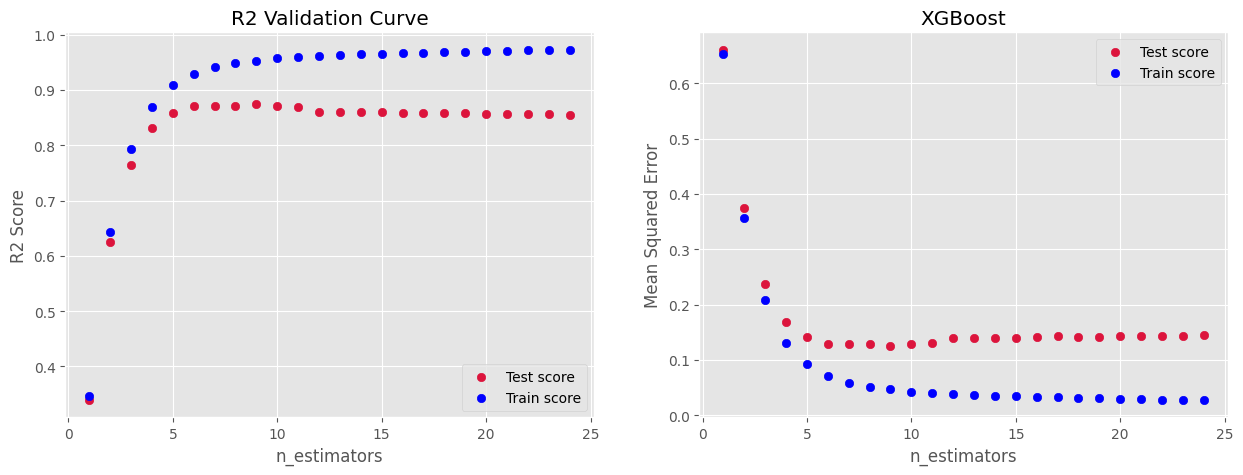

In [166]:
n_estimators_list = np.arange(1, 25, 1)
store_score = [] # [[r2, mse, mae], ...]
store_score_train = []

for n in n_estimators_list:
    model_temp = XGBRegressor()
    model_temp.set_params(n_estimators=n) # edit here
    model_temp.fit(X_train_new, y_train_new)
    store_score.append(ee.make_predict_score(y_eval, model_temp.predict(X_eval)))
    store_score_train.append(ee.make_predict_score(y_train_new, model_temp.predict(X_train_new)))

store_score = np.array(store_score)
store_score_train = np.array(store_score_train)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# r2
ax[0].scatter(n_estimators_list, store_score[:, 0], c='crimson', label='Test score')
ax[0].scatter(n_estimators_list, store_score_train[:, 0], c='blue', label='Train score')
ax[0].set_title('R2 Validation Curve')
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('R2 Score')
ax[0].legend()
# mse
ax[1].scatter(n_estimators_list, store_score[:, 1], c='crimson', label='Test score')
ax[1].scatter(n_estimators_list, store_score_train[:, 1], c='blue', label='Train score')
ax[1].set_title('MSE Validation Curve')
ax[1].set_xlabel('n_estimators')
ax[1].set_ylabel('Mean Squared Error')
ax[1].legend(loc='best')
plt.title('XGBoost') # edit here
plt.show()

Not a good idea to iterate n_estimators and fix other hyperparameters to get sense of propoer number of estimators. -> use random search with desired search space

In [ ]:
# Tune XGBoost
model_xgb = XGBRegressor(booster='gbtree',
                         verbosity=0)

params_dist = [{"n_estimators": [100],
                "max_depth": [4, 6, 8, 10],
                "learning_rate": [0.01, 0.05, 0.1, 0.3],
                "subsample": [0.3, 0.5, 0.75, 1.0],
                "colsample_bytree": [0.4, 0.6 , 0.8, 1.0],
                "gamma": [0]}]

fit_params = {
    'early_stopping_rounds': 10,
    'eval_set': [(X_eval, y_eval)],
    'eval_metric': 'rmse',
}

search = HalvingRandomSearchCV(estimator=model_xgb,
                               param_distributions=params_dist,
                               cv=tscv,
                               scoring='neg_root_mean_squared_error',
                               refit=True, # by default
                               verbose=1,
                               random_state=0)

init_tune_time = time.time()
search.fit(X_train_new, y_train_new, **fit_params)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_xgb_tuned = search.best_estimator_
print(search.best_params_)
# {'subsample': 0.75, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

# save model by pickle
filename = "./model/model_xgb_tuned.pickle"
pickle.dump(model_xgb_tuned, open(filename, 'wb'))

In [ ]:
model_xgb_tuned = pickle.load(open(filename, 'rb'))

In [ ]:
# # using ntree_limit or set params

# # using ntree_limit
# prediction_test1= model_xgb_tuned.predict(X_test, ntree_limit=model_xgb_tuned\
#                                                                     .get_booster()\
#                                                                     .best_ntree_limit)

# # set params
# model_test = XGBRegressor(**model_xgb_tuned.get_params())
# model_test.set_params(n_estimators=model_xgb_tuned.best_ntree_limit)
# model_test.fit(X_train, y_train)
# prediction_test2 = model_test.predict(X_test)

# print("using ntree limit")
# ee.make_predict_score(y_test, prediction_test1, print_result=True)
# print()
# print("set_params then refit")
# ee.make_predict_score(y_test, prediction_test2, print_result=True)

In [ ]:
# # train on X_train_new and y_train_new
# prediction_xgb_tuned1= model_xgb_tuned.predict(X_test, ntree_limit=model_xgb_tuned\
#                                                                     .get_booster()\
#                                                                     .best_ntree_limit)

# # train on X_train and y_train
# model_xgb_copy = copy.deepcopy(model_xgb_tuned)
# model_xgb_tuned.fit(X_train, y_train)

# init_pred_time = time.time()
# prediction_xgb_tuned2 = model_xgb_tuned.predict(X_test, ntree_limit=model_xgb_copy\
#                                                                     .get_booster()\
#                                                                     .best_ntree_limit)
# end_pred_time = time.time() - init_pred_time

# print("not re-fit X_train (fit on X_train_new)")
# ee.make_predict_score(y_test, prediction_xgb_tuned1, print_result=True)
# print()
# print("re-fit X_train")
# ee.make_predict_score(y_test, prediction_xgb_tuned2, print_result=True)

In [ ]:
# # model_xgb_tuned.set_params(n_estimators=model_xgb_tuned.best_iteration+1)
# model_xgb_copy = copy.deepcopy(model_xgb_tuned)
# model_xgb_tuned.fit(X_train, y_train)

# init_pred_time = time.time()
# prediction_xgb_tuned = model_xgb_tuned.predict(X_test, ntree_limit=model_xgb_copy\
#                                                                     .get_booster()\
#                                                                     .best_ntree_limit)
# end_pred_time = time.time() - init_pred_time

CatBoost

In [ ]:
# # CatBoost default parameters
# model_catboost = MultiOutputRegressor(CatBoostRegressor())

# model_catboost.fit(X_train, y_train)
# prediction_catboost = model_catboost.predict(X_test)
# prediction_catboost_train = model_catboost.predict(X_train)

In [ ]:
# model_catboost = MultiOutputRegressor(CatBoostRegressor(loss_function="MultiRMSE", eval_metric="RMSE", task_type='CPU'))
model_catboost = CatBoostRegressor(loss_function="MultiRMSE", eval_metric="MultiRMSE", task_type='CPU')
# model_catboost = CatBoostRegressor(loss_function="MultiRMSE", task_type='CPU')

# params_dist = [{
#     'estimator__iterations': [300],
#     'estimator__learning_rate': [0.01, 0.05, 0.1, 0.3],
#     'estimator__depth': [4, 6, 8, 10],
#     # 'estimator__subsample': [0.75, 1.0],
#     'estimator__rsm': [0.4, 0.6],
#     # 'estimator__sampling_frequency': [0.4, 0.6],
#     'estimator__l2_leaf_reg': [0.1, 0.5, 1, 2, 4, 6, 8, 10]
# }]

params_dist = [{
    'iterations': [100],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    # 'subsample': [0.75, 1.0],
    'rsm': [0.4, 0.6],
    # 'sampling_frequency': [0.4, 0.6],
    'l2_leaf_reg': [0.1, 0.5, 1, 2, 4, 6, 8, 10]
}]

fit_params = {
    'early_stopping_rounds': 10,
    'eval_set': [(X_eval, y_eval)],
    # 'eval_metric': "MultiRMSE",
    'verbose': False
}

search = HalvingRandomSearchCV(estimator=model_catboost,
                               param_distributions=params_dist,
                               cv=tscv,
                               scoring='neg_root_mean_squared_error',
                               verbose=1
                               )
init_tune_time = time.time()
search.fit(X_train_new, y_train_new, **fit_params)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
cat_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = "./model/model_catboost_tuned.pickle"
pickle.dump(cat_tuned, open(filename, 'wb'))

In [72]:
cat_tuned = pickle.load(open(filename, 'rb'))

In [82]:
# cat_best_params = cat_tuned.get_params()
# print(cat_best_params)
# print(cat_tuned.get_best_iteration())
# # {'rsm': 0.6, 'learning_rate': 0.05, 'l2_leaf_reg': 2, 'iterations': 300, 'depth': 4}

{'iterations': 100, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 1, 'rsm': 0.6, 'loss_function': 'MultiRMSE', 'eval_metric': 'MultiRMSE', 'task_type': 'CPU'}
63


In [ ]:
# model1 = CatBoostRegressor(**cat_best_params)

# model2 = CatBoostRegressor(**cat_best_params)
# model2.set_params(iterations=cat_tuned.get_best_iteration()+1)

# model3 = CatBoostRegressor(**cat_best_params)
# model3.set_params(iterations=300)

# model1.fit(X_train, y_train)
# model2.fit(X_train, y_train)
# model3.fit(X_train, y_train)

In [83]:
# print(ee.make_predict_score(y_test, cat_tuned.predict(X_test)), "\n")
# print(ee.make_predict_score(y_test, model1.predict(X_test)), "\n")
# print(ee.make_predict_score(y_test, model2.predict(X_test)), "\n")
# print(ee.make_predict_score(y_test, model3.predict(X_test)))

[0.8919, 0.1081, 0.1807]

[0.9045, 0.0955, 0.1565]

[0.8983, 0.1017, 0.1706]

[0.9216, 0.0784, 0.149]


In [ ]:
# model_catboost_tuned = CatBoostRegressor(**cat_best_params)
# model_catboost_tuned.set_params(iterations=cat_tuned.get_best_iteration()+1)
# model_catboost_tuned.fit(X_train, y_train)

In [ ]:
# prediction_catboost = model_catboost_tuned.predict(X_test)
# prediction_catboost_train = model_catboost_tuned.predict(X_train)

# prediction_catboost = scaler_y.inverse_transform(prediction_catboost)
# prediction_catboost_train = scaler_y.inverse_transform(prediction_catboost_train)

LightGBM

In [ ]:
model_lgbm = MultiOutputRegressor(LGBMRegressor())

params_dist = [{
    "estimator__boosting": ['goss'],
    "estimator__n_estimators": [100], # from early stopping criterion and validation curve
    "estimator__learning_rate": [0.1, 0.3],
    "estimator__max_depth": [6, 15],
    "estimator__num_leaves": [63, 255],
    "estimator__lambda_l1": [0.5, 1],
    "estimator__lambda_l2": [0, 0.5],
    "estimator__min_data_in_leaf": [20, 500],
    "estimator__max_bin": [127, 255],
    "estimator__feature_fraction": [1],
    "estimator__subsample": [0.5, 1],
    "estimator__verbose": [-1]
}]

evals_set = [(X_eval, y_eval[:,0]), (X_eval, y_eval[:,1]), (X_eval, y_eval[:,2]), (X_eval, y_eval[:,3])]

search = HalvingRandomSearchCV(estimator=model_lgbm,
                               param_distributions=params_dist,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               verbose=1)
init_tune_time = time.time()
search.fit(X_train_new, y_train_new, eval_set=evals_set, early_stopping_rounds=10, eval_metric="mean_squared_error", verbose=False)
end_tune_time = time.time() - init_tune_time

In [ ]:
print(f'tune time: %0.3f s' % end_tune_time)
model_lgbm_tuned = search.best_estimator_
print(search.best_params_)

# save model by pickle
filename = './model/model_lgbm_tuned.pickle'
pickle.dump(model_lgbm_tuned, open(filename, 'wb'))

In [125]:
model_lgbm_tuned = pickle.load(open(filename, 'rb'))

In [56]:
# lgbm_best_params = model_lgbm_tuned.estimator.get_params()
# print(model_lgbm_tuned.estimator)
# print(model_lgbm_tuned.estimators_[0].best_iteration_)

# best_trees = []
# for m in model_lgbm_tuned.estimators_:
#     best_trees.append(m.best_iteration_)

# mean_best_trees = np.mean(best_trees)
# print(best_trees, "mean num_trees:", mean_best_trees, f"({int(np.mean(best_trees))+1})")

LGBMRegressor(boosting='goss', feature_fraction=1, lambda_l1=0.5, lambda_l2=0.5,
              learning_rate=0.3, max_bin=127, max_depth=15, min_data_in_leaf=20,
              num_leaves=63, subsample=0.5, verbose=0)
3
[3, 3, 4, 4] mean num_trees: 3.5 (4)


In [ ]:
# prediction_lgbm = model_lgbm_tuned.predict(X_test)
# prediction_lgbm_train = model_lgbm_tuned.predict(X_train)

# prediction_lgbm = scaler_y.inverse_transform(prediction_lgbm)
# prediction_lgbm_train = scaler_y.inverse_transform(prediction_lgbm_train)

---

## 6. Model Evaluation

0. Baseline
1. DecisionTree
2. RandomForest
3. SVR (variant)
4. Linear_SVR
5. GBM
6. HistGBM
7. Adaboost
8. XGBoost
9. CatBoost
10. LightGBM

Reproduce dataset for re-train saved models

In [133]:
df_sample = pd.read_parquet('df_sample.parquet')
X, y = ee.sep_input_output(df_sample)
X_train, X_test, y_train, y_test = ee.train_test_split_data(X, y, train_size=0.8)
scaler = StandardScaler()
scaler_X = copy.deepcopy(scaler)
scaler_y = copy.deepcopy(scaler)
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.fit_transform(y_test)

In [134]:
score_df = ee.init_score_df()
fit_time = []

In [ ]:
models = [(DecisionTreeRegressor(), 'model_DT_tuned.joblib'),
          (RandomForestRegressor(), 'model_RF_tuned.joblib'),
          (MultiOutputRegressor(LinearSVR()), 'model_linear_svr_tuned.pickle'),
          (MultiOutputRegressor(SVR()), 'model_svr_tuned.pickle'),
          (MultiOutputRegressor(GradientBoostingRegressor()), 'model_GBM_tuned.pickle'),
          (MultiOutputRegressor(HistGradientBoostingRegressor()), 'model_histgbm_tuned.pickle'),
          (MultiOutputRegressor(AdaBoostRegressor()), 'model_adaboost_tuned.pickle'),
          (XGBRegressor(), 'model_xgb_tuned.pickle'),
          (MultiOutputRegressor(CatBoostRegressor()), 'model_catboost_tuned.pickle'),
          (MultiOutputRegressor(LGBMRegressor()), 'model_lgbm_tuned.pickle') 
]

for model in models:
    print(model[-1])
    model_default = model[0]

    if model[-1].split('.')[-1] == 'joblib':
        model_tuned = joblib.load(f'./model/{model[-1]}')
    elif model[-1].split('.')[-1] == 'pickle':
        model_tuned = pickle.load(open(f'./model/{model[-1]}', 'rb'))
    
    # refit model
    init_fit_time = time.time()
    model_default.fit(X_train, y_train)
    end_fit_time = time.time() - init_fit_time

    # save fit time
    fit_time.append(end_fit_time)

    init_fit_time = time.time()
    model_tuned.fit(X_train, y_train)
    end_fit_time = time.time() - init_fit_time

    # save fit time
    fit_time.append(end_fit_time)

    # predict
    temp_pred_default = model_default.predict(X_test)
    temp_pred_tuned = model_tuned.predict(X_test
    )

    # add score to score dataframe
    causal = model[-1].split('.')[0].replace('tuned', 'default')
    score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, temp_pred_default), causal)
    causal = model[-1].split('.')[0]
    score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, temp_pred_tuned), causal)
score_df.insert(loc=3, value=fit_time, column='fit_time')

In [153]:
# score_df.to_parquet('./Project Progress/score_compare/final_model_compare.parquet')

In [259]:
score_df = pd.read_parquet('./Project Progress/compare_score/final_model_compare.parquet')
score_df

,R-squared,MSE,MAE,fit_time,causal
0,0.8599,0.1401,0.1828,0.55,model_DT_default
1,0.8757,0.1243,0.1679,0.11,model_DT_tuned
2,0.9265,0.0735,0.1383,46.06,model_RF_default
3,0.9308,0.0692,0.1371,47.34,model_RF_tuned
4,0.7569,0.2431,0.3265,6.19,model_linear_svr_default
5,0.7005,0.2995,0.3839,20.89,model_linear_svr_tuned
6,0.8575,0.1425,0.2653,107.67,model_svr_default
7,0.7761,0.2239,0.3484,220.74,model_svr_tuned
8,0.9138,0.0862,0.1605,49.16,model_GBM_default
9,0.9170,0.0830,0.1479,12.41,model_GBM_tuned


Hard to compare the results with a table -> visualize to heatmap

[Text(0.5, 0, '')]

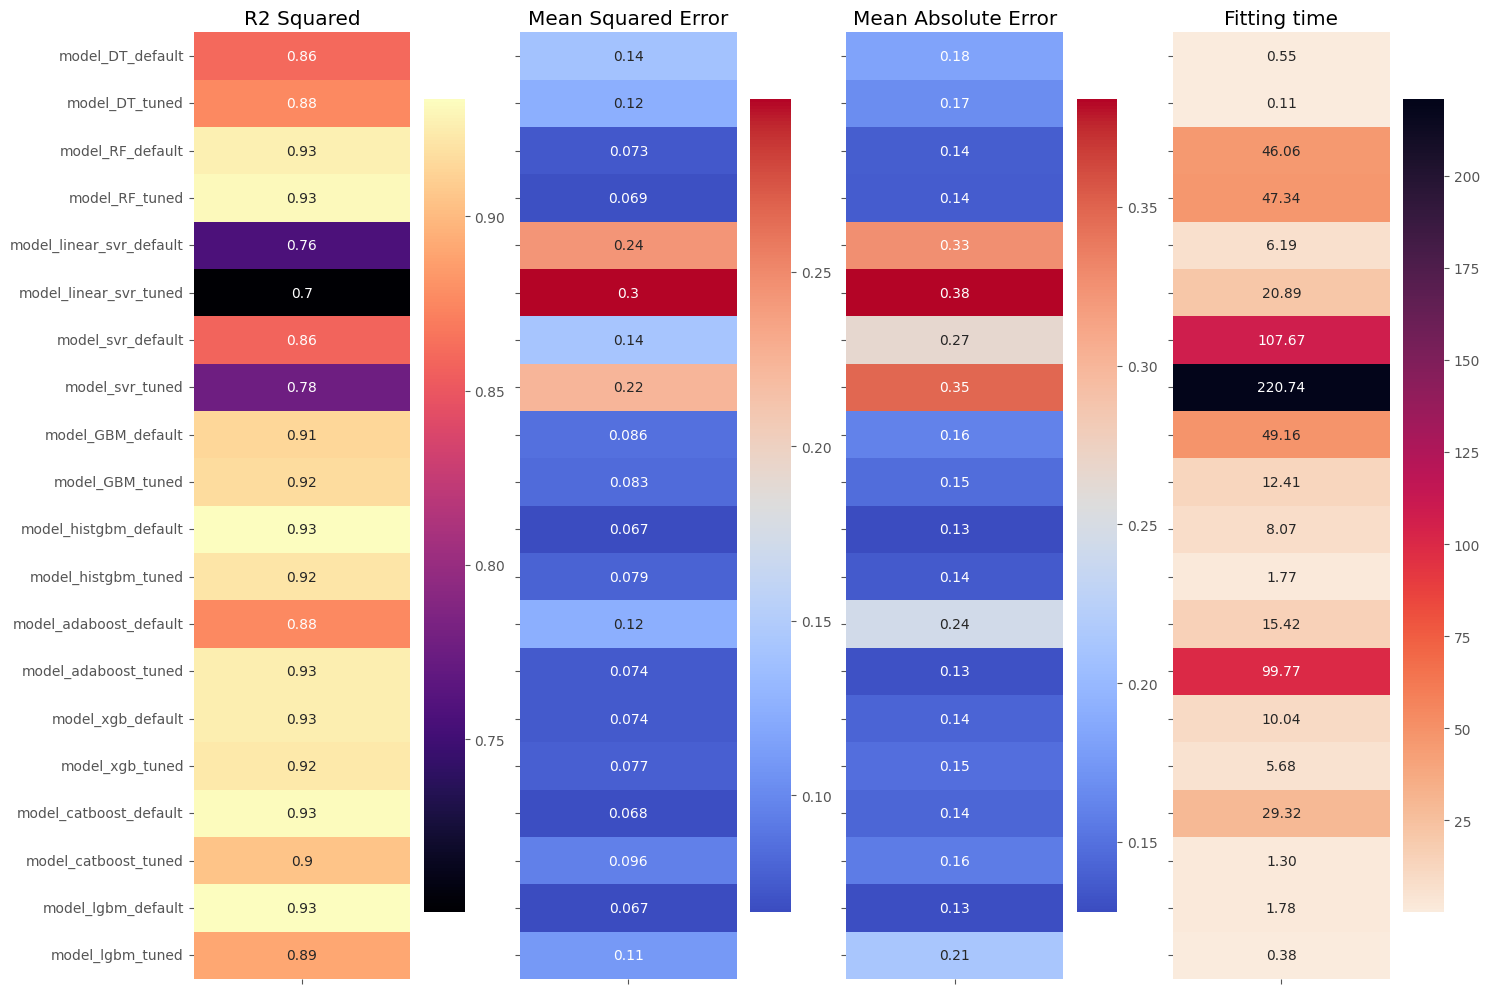

In [159]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 10), sharey=True)

sns.heatmap(pd.DataFrame(score_df.set_index('causal').iloc[:, 0], score_df.causal.tolist()), cmap='magma', cbar=True, annot=True, ax=axs[0])
axs[0].set_title('R2 Squared')
axs[0].set_xticklabels('')

sns.heatmap(pd.DataFrame(score_df.set_index('causal').iloc[:, 1], score_df.causal.tolist()), cmap='coolwarm', cbar=True, annot=True, ax=axs[1])
axs[1].set_title('Mean Squared Error')
axs[1].set_xticklabels('')

sns.heatmap(pd.DataFrame(score_df.set_index('causal').iloc[:, 2], score_df.causal.tolist()), cmap='coolwarm', cbar=True, annot=True, ax=axs[2])
axs[2].set_title('Mean Absolute Error')
axs[2].set_xticklabels('')

sns.heatmap(pd.DataFrame(score_df.set_index('causal').iloc[:, 3], score_df.causal.tolist()), cmap='rocket_r', cbar=True, annot=True, fmt='.2f',ax=axs[3])
axs[3].set_title('Fitting time')
axs[3].set_xticklabels('')

## Imputation Evaluation

In [214]:
# model = joblib.load("./model/model_RF_tuned.joblib")
# model = pickle.load(open("./model/model_lgbm_tuned.pickle", 'rb'))
model = XGBRegressor()

In [215]:
def sep_scale(df_sample):
    X, y = ee.sep_input_output(df_sample)
    X_train, X_test, y_train, y_test = ee.train_test_split_data(X, y, train_size=0.8)

    scaler = StandardScaler()
    scaler_X = copy.deepcopy(scaler)
    scaler_y = copy.deepcopy(scaler)
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.fit_transform(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
save_score = []
time_score = []

# not impute
print('not impute')
init = time.time()
df_temp = df.copy()
df_temp = ee.process_data(df_temp)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# fill with constant 0
print('fill with constant 0')
init = time.time()
df_temp = ee.set_date_as_index(df)
df_temp = ee.create_timeseries_features(df_temp)
for col in df_temp.columns:
    df_temp[col] = df_temp[col].fillna(0)
df_temp = ee.sum_features(df_temp)
df_temp = ee.create_features(df_temp)
df_temp = ee.set_index_as_index(df_temp)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# fill with mean
print('fill with mean')
init = time.time()
df_temp = ee.set_date_as_index(df)
df_temp = ee.create_timeseries_features(df_temp)
for col in df_temp.columns:
    df_temp[col] = df_temp[col].fillna(df_temp[col].mean())
df_temp = ee.sum_features(df_temp)
df_temp = ee.create_features(df_temp)
df_temp = ee.set_index_as_index(df_temp)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# median
print('fill with median')
init = time.time()
df_temp = ee.set_date_as_index(df)
df_temp = ee.create_timeseries_features(df_temp)
for col in df_temp.columns:
    df_temp[col] = df_temp[col].fillna(df_temp[col].median())
df_temp = ee.sum_features(df_temp)
df_temp = ee.create_features(df_temp)
df_temp = ee.set_index_as_index(df_temp)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# mean and groupby
print('fill with mean and groupby')
init = time.time()
imputer_meangroupby_transformer = FunctionTransformer(ee.imputer_meangroupby)
df_temp = imputer_meangroupby_transformer.fit_transform(df)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# Iterative Imputer
print('fill with Iterative Imputer')
init = time.time()
imputer_iterative_transformer = FunctionTransformer(ee.imputer_iterative, kw_args={'zone': zone})
df_temp = imputer_iterative_transformer.fit_transform(df)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# KNN
print('fill with KNN')
init= time.time()
imputer_knn_transformer = FunctionTransformer(ee.imputer_knn, kw_args={'zone': zone})
df_temp = imputer_knn_transformer.fit_transform(df)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

# NanImputer
print('fill with NaNImputer')
init = time.time()
imputer_nan = NaNImputer(train_sample_size=df.shape[0], verbose=False)
df_temp = imputer_nan.impute(df)
df_temp = ee.process_data(df_temp)
time_score.append(time.time()-init)
X_train, X_test, y_train, y_test = sep_scale(df_temp)
model.fit(X_train, y_train)
save_score.append(ee.make_predict_score(y_test, model.predict(X_test)))

In [166]:
causals = ['not impute', 'constant 0', 'mean', 'median', 'mean and groupby', 
           'IterativeImputer', 'KNN', 'NaNImputer']
score = ee.init_score_df()
for i, e in enumerate(zip(save_score, causals)):
    # print(i, e[0], e[1], e)
    score = ee.insert_score(score, e[0], e[1])
time_perform = [round(x, 2) for x in time_score]
score.insert(loc=3, value=time_perform, column='time_perform')
score

,R-squared,MSE,MAE,time_perform,causal
0,0.8529,0.1471,0.2365,0.12,not impute
1,0.8372,0.1628,0.2464,0.16,constant 0
2,0.8593,0.1407,0.2294,0.19,mean
3,0.8561,0.1439,0.2341,0.19,median
4,0.8565,0.1435,0.2364,0.42,mean and groupby
5,0.8669,0.1331,0.2339,1.99,IterativeImputer
6,0.8906,0.1094,0.2127,111.21,KNN
7,0.8786,0.1214,0.2143,8.74,NaNImputer


In [3]:
# score.to_parquet('./Project Progress/compare_score/final_imputation.parquet')
score = pd.read_parquet('./Project Progress/compare_score/final_imputation.parquet')

[Text(0.5, 0, '')]

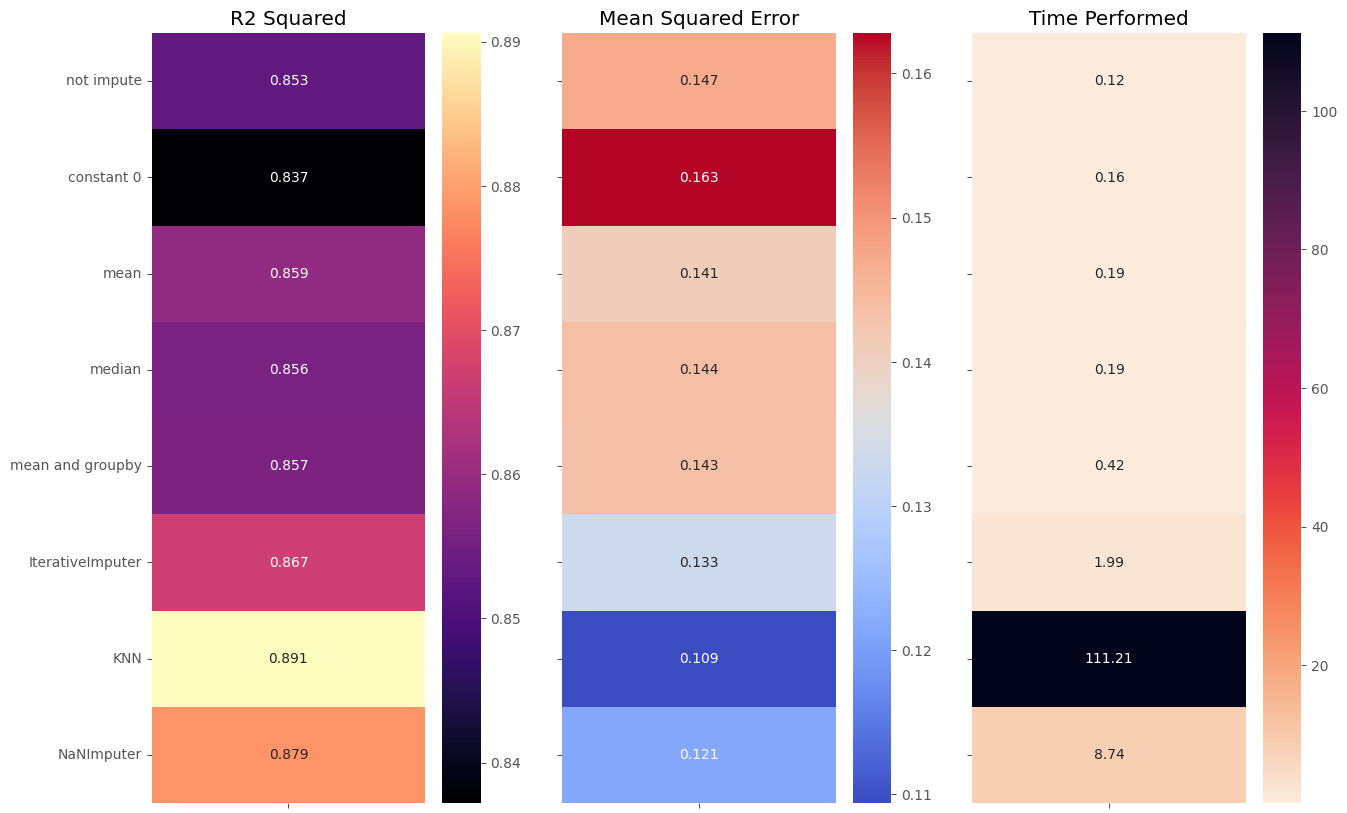

In [197]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 10), sharey=True)

sns.heatmap(pd.DataFrame(score.set_index('causal').iloc[:, 0], score.causal.tolist()), cmap='magma', cbar=True, annot=True, fmt='.3f', ax=axs[0])
axs[0].set_title('R2 Squared')
axs[0].set_xticklabels('')

sns.heatmap(pd.DataFrame(score.set_index('causal').iloc[:, 1], score.causal.tolist()), cmap='coolwarm', cbar=True, annot=True, fmt='.3f', ax=axs[1])
axs[1].set_title('Mean Squared Error')
axs[1].set_xticklabels('')

sns.heatmap(pd.DataFrame(score.set_index('causal').iloc[:, 3], score.causal.tolist()), cmap='rocket_r', cbar=True, annot=True, fmt='.2f', ax=axs[2])
axs[2].set_title('Time Performed')
axs[2].set_xticklabels('')

Alternative way to evaluate imputation performance, seems not to be effective

Text(0.5, 1.0, 'MAE')

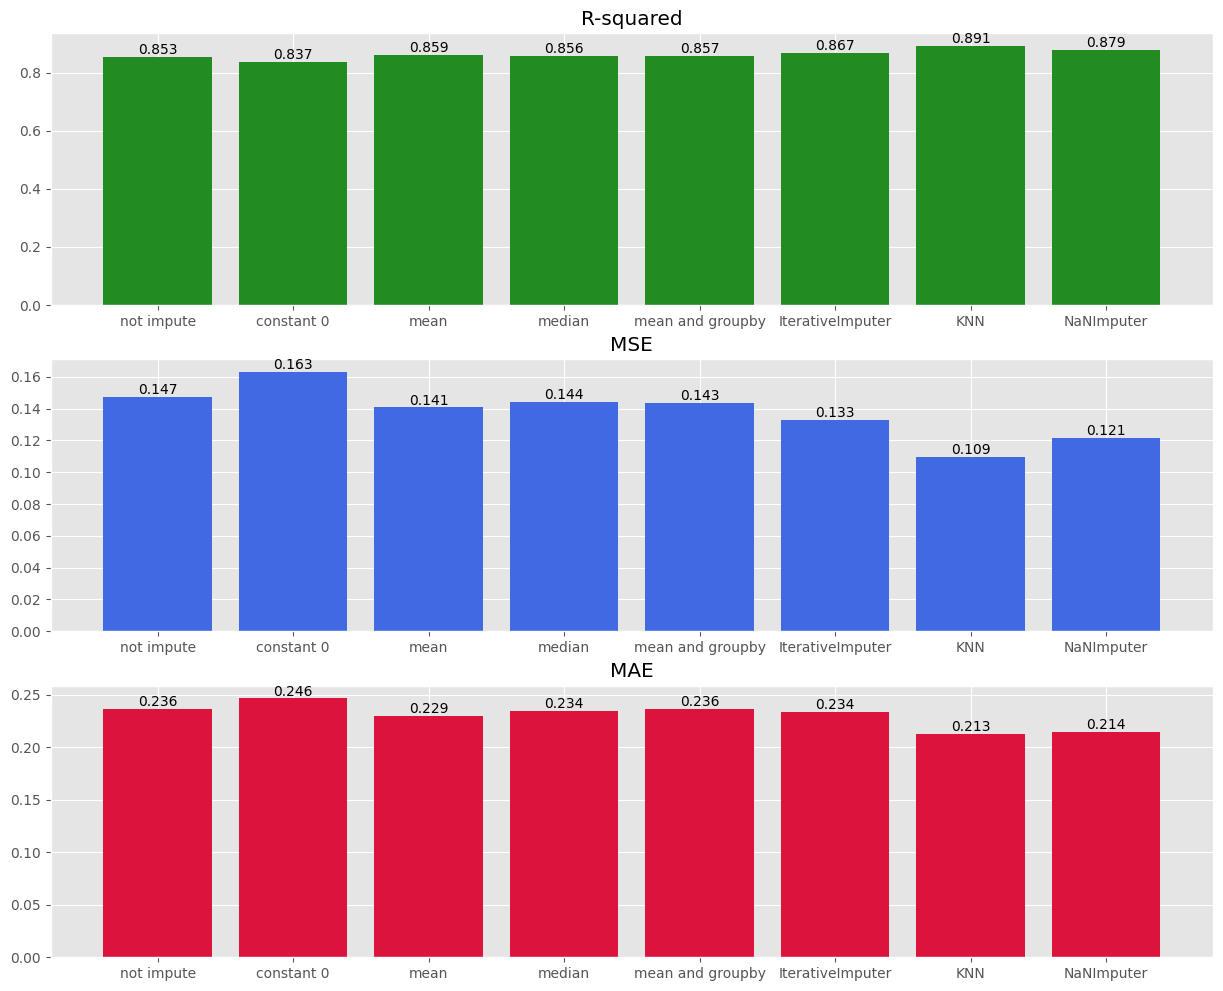

In [107]:
fig, ax = plt.subplots(3, figsize=(15, 12))

ax[0].bar(score['causal'], score['R-squared'].tolist(), color='forestgreen')
ax[0].bar_label(ax[0].containers[0], fmt="%.03f")
ax[0].set_xticklabels(score['causal'].tolist(), rotation=0)

ax[1].bar(score['causal'], score['MSE'].tolist(), color='royalblue')
ax[1].bar_label(ax[1].containers[0], fmt="%.03f")
ax[1].set_xticklabels(score['causal'].tolist(), rotation=0)

ax[2].bar(score['causal'], score['MAE'].tolist(), color='crimson')
ax[2].bar_label(ax[2].containers[0], fmt="%.03f")
ax[2].set_xticklabels(score['causal'].tolist(), rotation=0)

ax[0].set_title('R-squared')
ax[1].set_title('MSE')
ax[2].set_title('MAE')

## Scoring

summary score comparison

In [ ]:
score_df

In [ ]:
# score_df = ee.init_score_df()

In [ ]:
# causal = 'Baseline score'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, baseline_prediction), causal)

# causal = 'Decision Tree Regressor default parameters'
# score_df = insert_score(score_df, make_predict_score(y_test, prediction_DT), causal)
# causal = 'Decision Tree Regressor default parameters ON train set'
# score_df = insert_score(score_df, make_predict_score(y_train, prediction_DT_train), causal)

# causal = 'scikit-learn GBM tuned'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, prediction_gbm_tuned), causal)
# causal = 'scikit-learn GBM tuned ON train set'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_train, prediction_gbm_tuned_train), causal)

# causal = 'AdaBoost Tuned'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, prediction_adaboost_tuned), causal)
# causal = 'AdaBoost tuned ON train set'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_train, prediction_adaboost_tuned_train), causal)

# causal = 'XGBoost Tuned'
# score_df = ee.insert_score(score_df, ee.make_predict_score(y_test, prediction_xgb_tuned), causal)

In [131]:
pd.read_parquet("./Project Progress/compare_score/compare_score3(model).parquet")

,R-squared,MSE,MAE
Baseline score,-0.0002,451.3071,13.4449
Decision Tree Regressor default parameters,0.8926,60.0984,2.6901
Decision Tree Regressor default parameters ON train set,0.9153,40.9514,2.0323
Decision Tree Regressor tuned,0.8926,60.0984,2.6901
Decision Tree Regressor tuned ON train set,0.9153,40.9514,2.0323
Random Forest Regressor tuned,0.8928,55.9336,3.2829
Random Forest Regressor with HalvingRandomSearch tune ON train set,0.9016,47.3708,2.4763
SVR default parameters,0.6902,231.7871,6.1146
SVR default parameters ON train set,0.6420,289.3308,6.5296
scikit-learn GBM default parameters,0.9164,52.0318,2.9644


In [231]:
pd.read_parquet("./Project Progress/compare_score/compare_score4(scaling).parquet")

,R-squared,MSE,MAE,causal
0,0.8166,10.5885,1.1948,rf not scaled
1,0.8107,11.1556,1.2193,rf MinMaxScaler
2,0.8302,9.9952,1.2136,rf StandardScaler
3,0.8058,11.3918,1.2378,rf RobustScaler
4,0.8522,8.7144,1.3644,gbm not scaled
5,0.8510,8.7375,1.3666,gbm MinMaxScaler
6,0.8535,8.5211,1.3548,gbm StandardScaler
7,0.8515,8.7261,1.3644,gbm RobustScaler


In [222]:
# import pandas as pd
# score_df
# pd.read_parquet("./Project Progress/compare_score/compare_score2.parquet")
# score_df.to_parquet('./Project Progress/compare_score/compare_score4(scaling).parquet')
pd.read_parquet('./Project Progress/compare_score/compare_score5(final_imputation_1zone).parquet')

,R-squared,MSE,MAE,causal_data1zone
0,0.6666,22.5854,2.2089,IterativeImputer (Mean)
1,0.9253,4.2781,0.7758,KNNImputer
2,0.7433,16.1998,1.7265,Groupby and Mean
3,0.8332,11.6818,1.5152,LightGBM (NaNImputer)
4,0.8829,4.5183,0.9471,IterativeImputer (Median)


In [223]:
pd.read_parquet('./Project Progress/compare_score/compare_score6(final_imputation_1floor_xgboost).parquet')

,R-squared,MSE,MAE,causal_data1floor_xgboost
0,0.9035,63.4714,3.2765,IterativeImputer
1,0.9530,25.7234,1.7882,KNNImputer
2,0.8832,64.9825,3.6593,Groupby and Mean
3,0.8369,112.0734,5.1426,LightGBM (NaNImputer)


In [224]:
pd.read_parquet('./Project Progress/compare_score/compare_score6(final_imputation_1floor_decisionTree).parquet')

,R-squared,MSE,MAE,causal_data1floor_decisionTree
0,0.7287,174.6390,3.9339,IterativeImputer
1,0.8541,86.6915,2.6405,KNNImputer
2,0.7649,118.9754,3.5056,Groupby and Mean
3,0.8249,115.9444,3.2760,LightGBM (NaNImputer)


In [192]:
pd.read_parquet('./Project Progress/compare_score/compare_score2(impute).parquet')

,R-squared,MSE,MAE
Baseline score,-0.000200,451.307100,13.444900
Using IterativeImputer for each zone without timeseries features,0.885000,58.292900,3.402300
Using IterativeImputer for each zone without timeseries features ON train set,0.900300,47.636000,2.500800
Using IterativeImputer for each zone without timeseries features CV,0.840280,69.502632,3.827843
Using Groupby and Mean Imputation with timeseries features,0.887700,61.433100,3.377200
Using Groupby and Mean Imputation with timeseries features ON train set,0.850500,81.747100,3.318200
Using Groupby and Mean Imputation with timeseries features CV,0.678478,158.615994,5.798127
Using IterativeImputer for each zone with timeseries features,0.849700,85.785000,4.056500
Using IterativeImputer for each zone with timeseries features ON train set,0.894100,52.075300,2.729400
Using IterativeImputer for each zone with timeseries features CV,0.826602,81.833750,4.307022


### Visualization

Imputation

In [6]:
ixd = df[[col for col in df.columns if 'kW' in col]].isnull().any(axis=1)
ix = df.loc[ixd == True].index

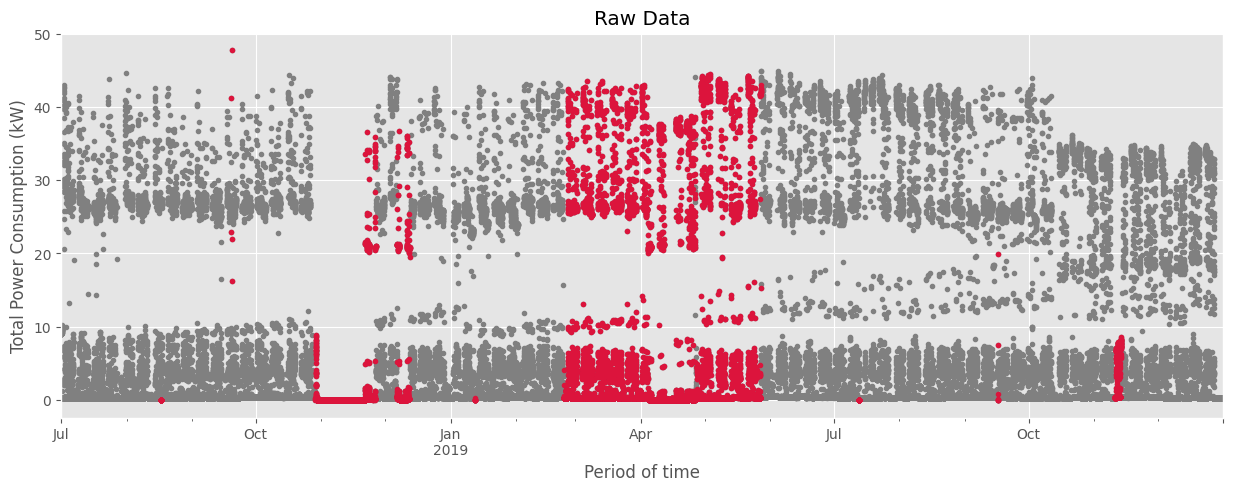

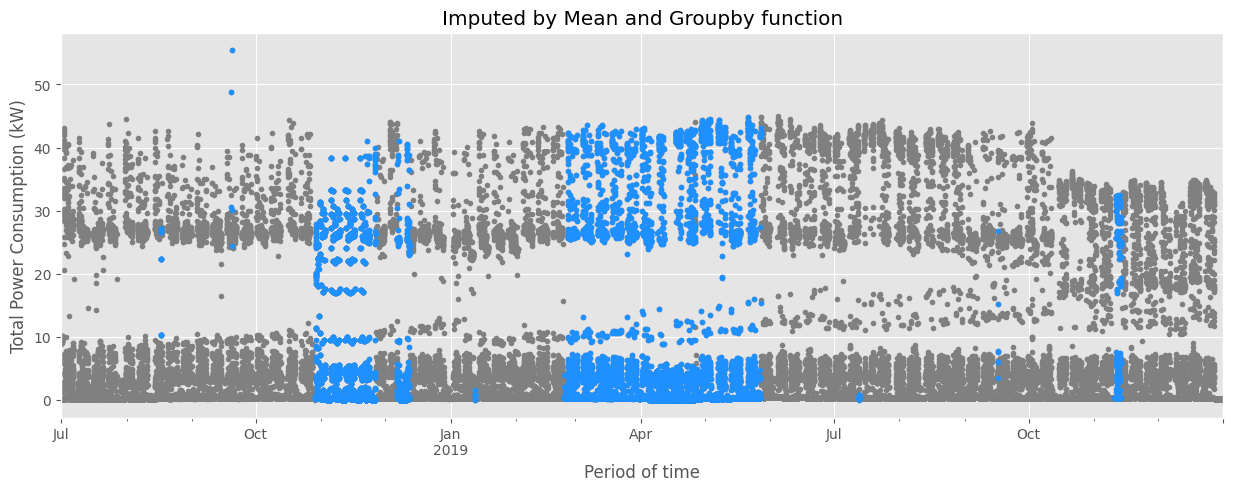

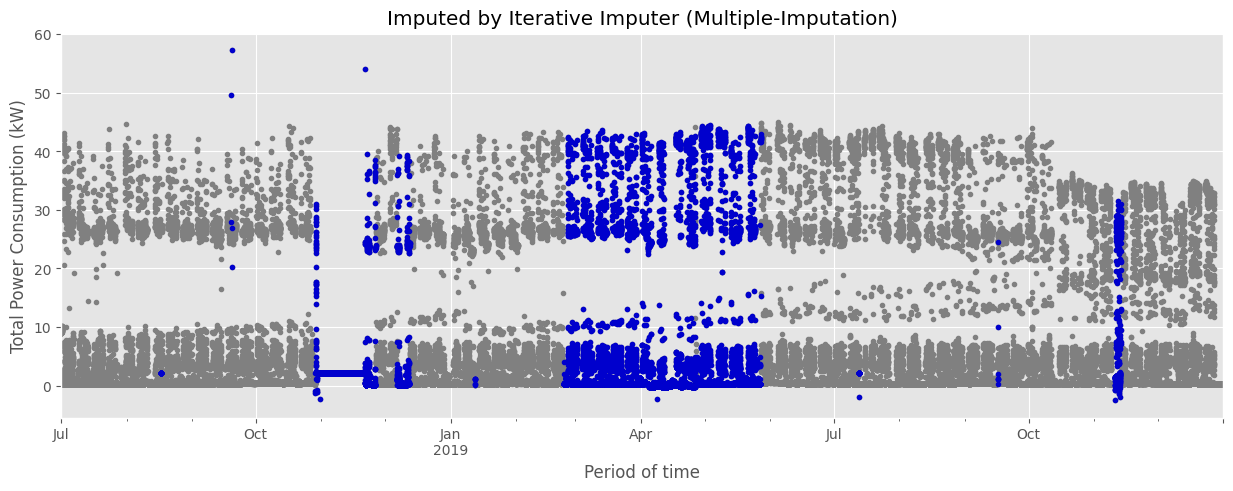

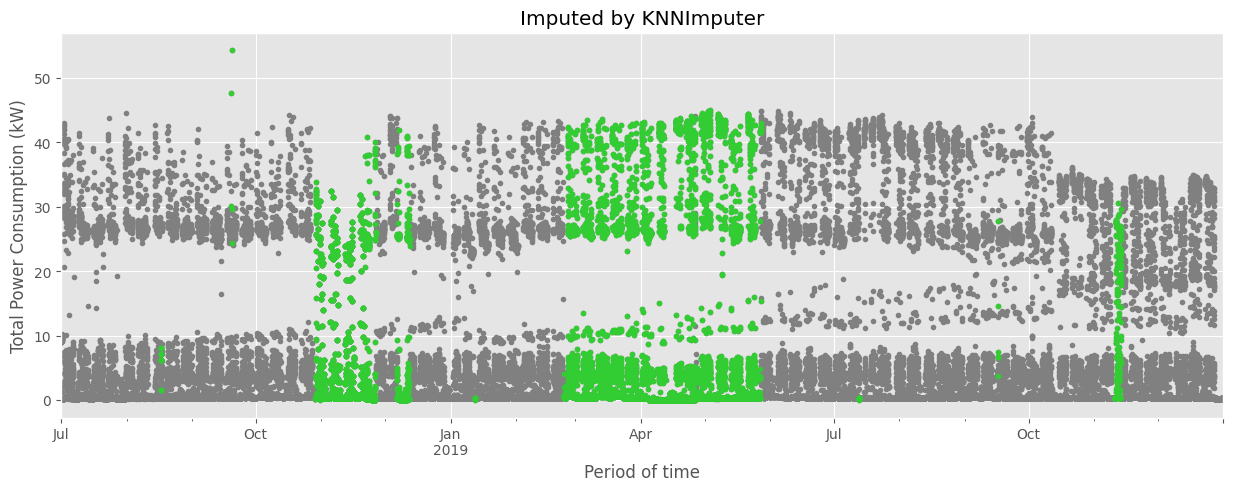


Time elapsed for impute execution: 5.05765 seconds


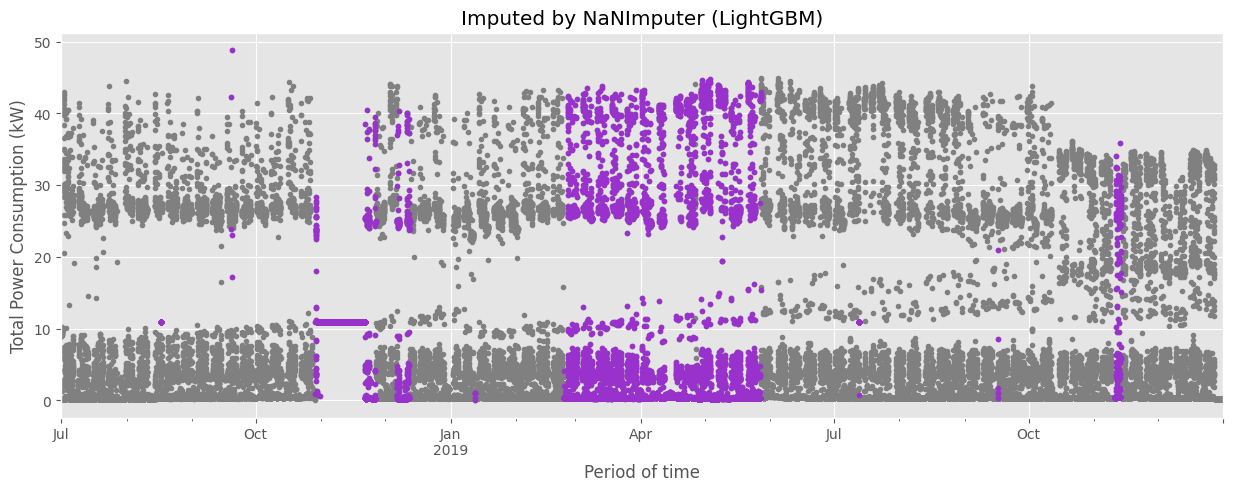

In [7]:
df_temp = df.copy()
df_temp = ee.process_data(df_temp)
df_temp = ee.set_date_as_index(df_temp)
ax = df_temp['sum_power_consumption(kW)'].plot(figsize=(15, 5), style='.', color='grey')
df_temp['sum_power_consumption(kW)'][ix].plot(style='.', color='crimson', ax=ax)
plt.title('Raw Data')
plt.xlabel('Period of time')
plt.ylabel('Total Power Consumption (kW)')
plt.show()

imputer_meangroupby_transformer = FunctionTransformer(ee.imputer_meangroupby)
df_temp = imputer_meangroupby_transformer.fit_transform(df)
df_temp = ee.set_date_as_index(df_temp)
ax = df_temp['sum_power_consumption(kW)'].plot(figsize=(15, 5), style='.', color='grey')
df_temp['sum_power_consumption(kW)'][ix].plot(style='.', color='dodgerblue', ax=ax)
plt.title('Imputed by Mean and Groupby function')
plt.xlabel('Period of time')
plt.ylabel('Total Power Consumption (kW)')
plt.show()

imputer_iterative_transformer = FunctionTransformer(ee.imputer_iterative, kw_args={'zone': zone})
df_temp = imputer_iterative_transformer.fit_transform(df)
df_temp = ee.set_date_as_index(df_temp)
ax = df_temp['sum_power_consumption(kW)'].plot(figsize=(15, 5), style='.', color='grey')
df_temp['sum_power_consumption(kW)'][ix].plot(style='.', color='mediumblue', ax=ax)
plt.title('Imputed by Iterative Imputer (Multiple-Imputation)')
plt.xlabel('Period of time')
plt.ylabel('Total Power Consumption (kW)')
plt.show()

imputer_knn_transformer = FunctionTransformer(ee.imputer_knn, kw_args={'zone': zone})
df_temp = imputer_knn_transformer.fit_transform(df)
df_temp = ee.set_date_as_index(df_temp)
ax = df_temp['sum_power_consumption(kW)'].plot(figsize=(15, 5), style='.', color='grey')
df_temp['sum_power_consumption(kW)'][ix].plot(style='.', color='limegreen', ax=ax)
plt.title('Imputed by KNNImputer')
plt.xlabel('Period of time')
plt.ylabel('Total Power Consumption (kW)')
plt.show()

imputer_nan = NaNImputer(train_sample_size=df.shape[0], verbose=False)
df_temp = imputer_nan.impute(df)
df_temp = ee.process_data(df_temp)
df_temp = ee.set_date_as_index(df_temp)
ax = df_temp['sum_power_consumption(kW)'].plot(figsize=(15, 5), style='.', color='grey')
df_temp['sum_power_consumption(kW)'][ix].plot(style='.', color='darkorchid', ax=ax)
plt.title('Imputed by NaNImputer (LightGBM)')
plt.xlabel('Period of time')
plt.ylabel('Total Power Consumption (kW)')
plt.show()

Evaluate Feature Importance

In [4]:
X, y = ee.sep_input_output(df_sample)
X_train_old, X_test_old, y_train_old, y_test_old = ee.train_test_split_data(X, y, train_size=0.8)

In [5]:
# Fit scaler on input data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_old)
X_test = scaler_X.transform(X_test_old)

# # Fit scaler on output data
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_old)
y_test = scaler_y.transform(y_test_old)

In [6]:
X_train_scaled = pd.DataFrame(data=X_train, columns=X_train_old.columns).set_index(X_train_old.index)
X_test_scaled = pd.DataFrame(data=X_test, columns=X_test_old.columns).set_index(X_test_old.index)
y_train_scaled = pd.DataFrame(data=y_train, columns=y_train_old.columns).set_index(y_train_old.index)
y_test_scaled = pd.DataFrame(data=y_test, columns=y_test_old.columns).set_index(y_test_old.index)

[22:55:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



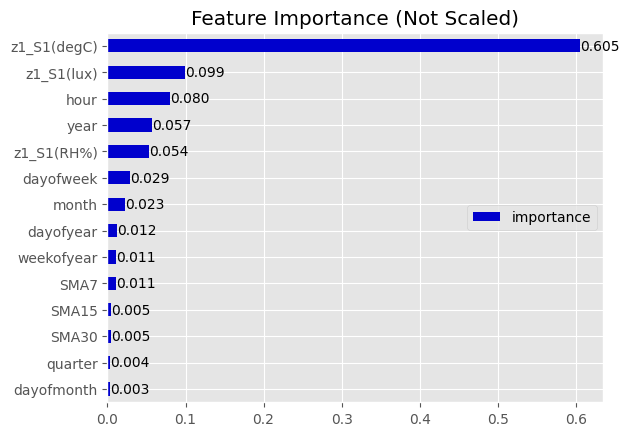

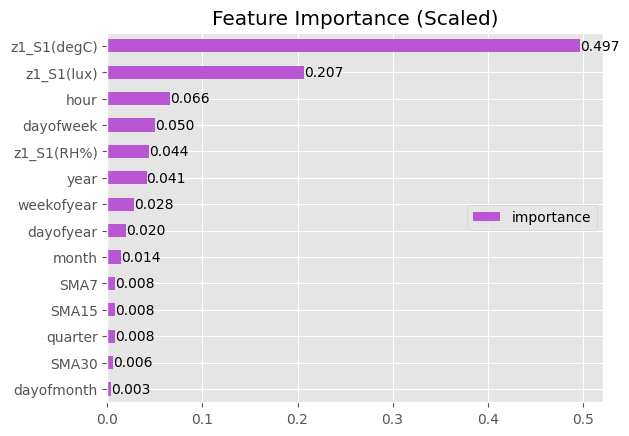

In [94]:
model_temp = pickle.load(open("./model/model_xgb_tuned.pickle", 'rb'))
model_temp.fit(X_train_old, y_train_old)
feature_important = pd.DataFrame(
    data=model_temp.feature_importances_,
    index=model_temp.feature_names_in_,
    columns=['importance']
)
ax = feature_important.sort_values('importance').plot(kind='barh', 
                                                      title='Feature Importance (Not Scaled)', color='mediumblue')
ax.bar_label(ax.containers[0], fmt="%.03f")
ax.legend(loc='right')
plt.show()

model_temp.fit(X_train_scaled, y_train_scaled)
feature_important = pd.DataFrame(
    data=model_temp.feature_importances_,
    index=model_temp.feature_names_in_,
    columns=['importance']
)
ax = feature_important.sort_values('importance').plot(kind='barh', 
                                                      title='Feature Importance (Scaled)', color='mediumorchid')
ax.bar_label(ax.containers[0], fmt="%.03f")
ax.legend(loc='right')
plt.show()

Evalute Scaling effect

In [19]:
# create a new model and score dataframe
temp_score = ee.init_score_df()
model_temp = XGBRegressor()

# not scaling result
model_temp.fit(X_train_old, y_train_old)
temp_pred = model_temp.predict(X_test_old)
temp_score = ee.insert_score(temp_score, ee.make_predict_score(y_test_old, temp_pred), 'not scaled')

# scaling result
model_temp.fit(X_train_scaled, y_train_scaled)
temp_pred_scaled = model_temp.predict(X_test_scaled)

temp_pred2 = scaler_y.inverse_transform(temp_pred_scaled)
y_test_temp = scaler_y.inverse_transform(y_test_scaled)

temp_score = ee.insert_score(temp_score, ee.make_predict_score(y_test_temp, temp_pred2), 'scaled')

In [20]:
temp_score

,R-squared,MSE,MAE,causal
0,0.9200,4.5449,0.8065,not scaled
1,0.9253,4.2781,0.7758,scaled


Model Prediction

In [346]:
# model = joblib.load("./model/model_DT_tuned.joblib")
# model = joblib.load("./model/model_RF_tuned.joblib")
# model = pickle.load(open("./model/model_lgbm_tuned.pickle", 'rb'))
# model = RandomForestRegressor()
model = MultiOutputRegressor(LGBMRegressor())
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [347]:
df_temp = df_sample.copy()
df_temp = ee.set_date_as_index(df_temp)

In [348]:
pred_not_scaled = scaler_y.inverse_transform(pred)

In [349]:
# y_test must not be scaled to execute this cell
y_temp = y_test_not_scaled.copy()
y_temp['prediction'] = pred_not_scaled[:, 3] # edit this line
df_temp = df_temp.join(y_temp[['prediction']])

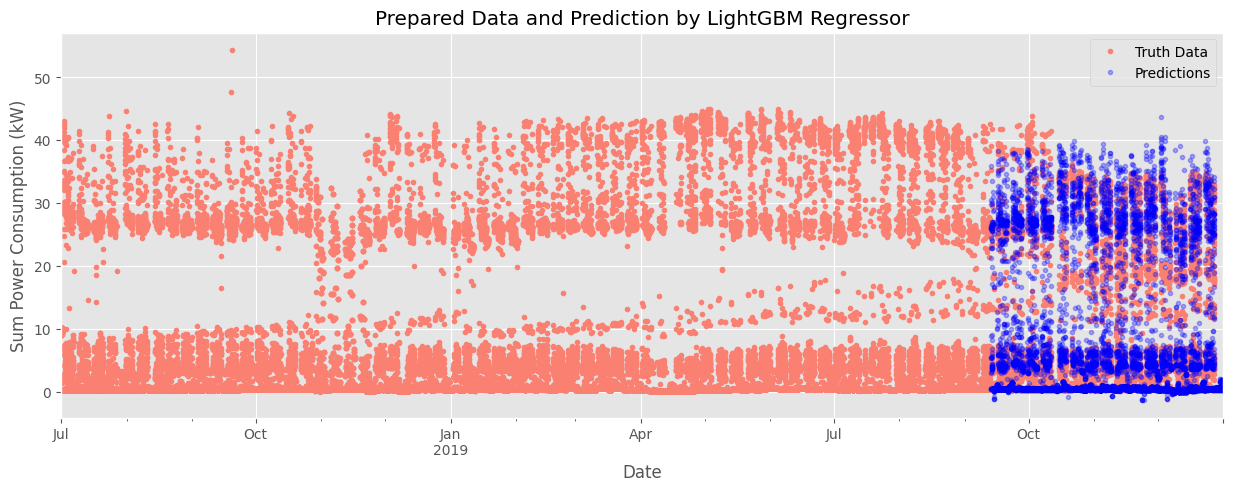

In [356]:
color_temp = 'blue'
model = 'LightGBM Regressor'
ax = df_temp[['sum_power_consumption(kW)']].plot(figsize=(15, 5), style='.', color='salmon')
df_temp['prediction'].plot(ax=ax, style='.', color=color_temp, alpha=0.3)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title(f'Prepared Data and Prediction by {model}')
plt.ylabel('Sum Power Consumption (kW)')
plt.show()

# ax = df_temp[['sum_power_consumption(kW)']].plot(figsize=(15, 5), style='.', color='royalblue')
# ax.set_title('Without Prediction')
# plt.show()

# ax = ee.set_date_as_index(ee.process_data(df))[['sum_power_consumption(kW)']].plot(figsize=(15, 5), style='.', color='grey')
# ax.set_title('Raw Data')
# plt.show()

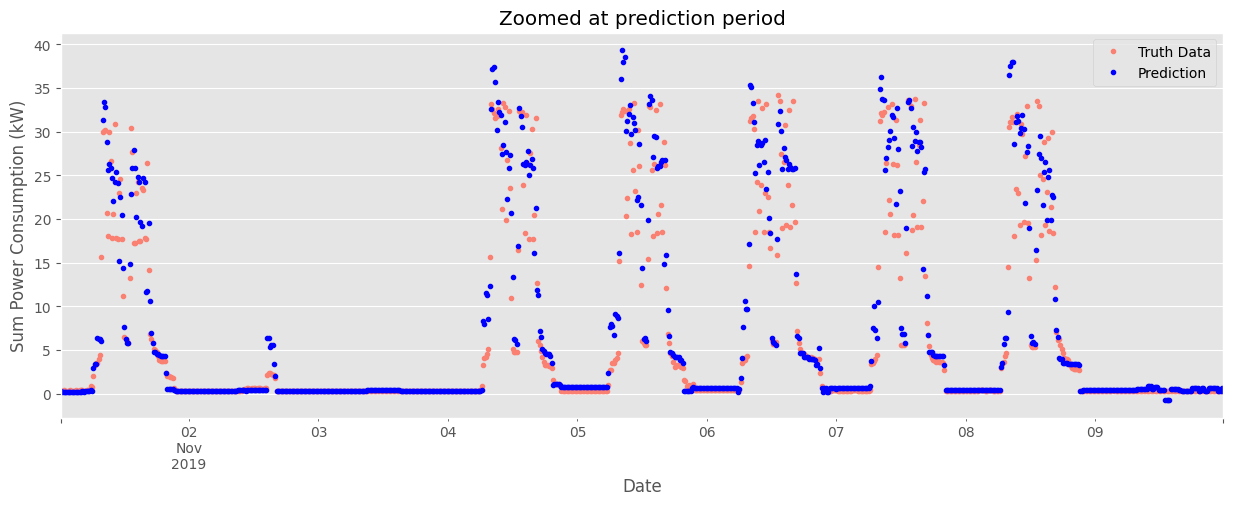

In [357]:
month = '11'
ax = df_temp.loc[(df_temp.index > f'2019-{month}-01') & (df_temp.index < f'2019-{month}-10')]['sum_power_consumption(kW)'] \
       .plot(figsize=(15, 5), title='Zoomed at prediction period', style='.', color='salmon')
df_temp.loc[(df_temp.index > f'2019-{month}-01') & (df_temp.index < f'2019-{month}-10')]['prediction'] \
  .plot(style='.', color=color_temp)
plt.legend(['Truth Data','Prediction'])
plt.ylabel('Sum Power Consumption (kW)')
plt.show()

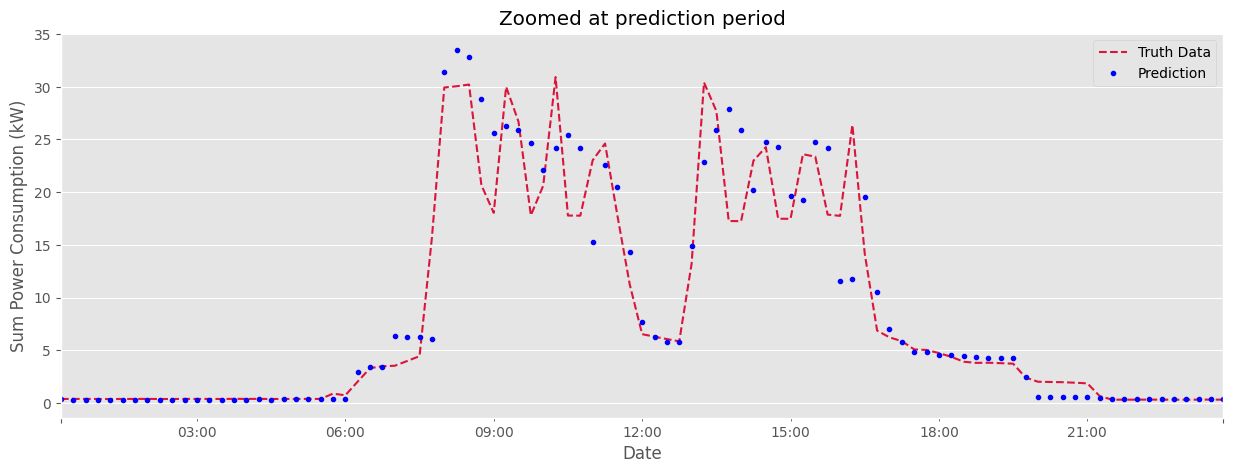

In [358]:
ax = df_temp.loc[(df_temp.index > f'2019-{month}-01') & (df_temp.index < f'2019-{month}-02')]['sum_power_consumption(kW)'] \
       .plot(figsize=(15, 5), title='Zoomed at prediction period', style='--', color='crimson')
df_temp.loc[(df_temp.index > f'2019-{month}-01') & (df_temp.index < f'2019-{month}-02')]['prediction'] \
  .plot(style='.', color=color_temp)
plt.legend(['Truth Data','Prediction'])
plt.ylabel('Sum Power Consumption (kW)')
plt.show()

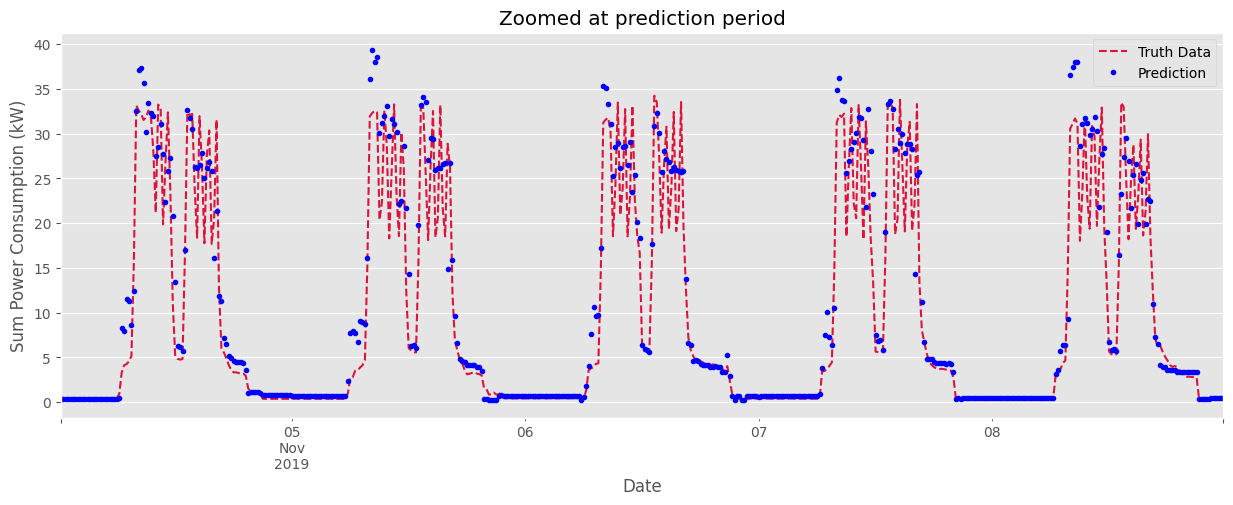

In [359]:
ax = df_temp.loc[(df_temp.index > f'2019-{month}-04') & (df_temp.index < f'2019-{month}-09')]['sum_power_consumption(kW)'] \
       .plot(figsize=(15, 5), title='Zoomed at prediction period', style='--', color='crimson')
df_temp.loc[(df_temp.index > f'2019-{month}-04') & (df_temp.index < f'2019-{month}-09')]['prediction'] \
  .plot(style='.', color=color_temp)
plt.legend(['Truth Data','Prediction'])
plt.ylabel('Sum Power Consumption (kW)')
plt.show()

check outlier from imputer

In [211]:
ix = df_sample.sort_values(by=['sum_power_consumption(kW)'], ascending=False).head(5)[['Date', 'sum_power_consumption(kW)']].index
df_sample.sort_values(by=['sum_power_consumption(kW)'], ascending=False).head(5)[['Date', 'sum_power_consumption(kW)']]

,Date,sum_power_consumption(kW)
7735,2018-09-19 13:45:00,54.344467
7733,2018-09-19 13:15:00,47.609500
29430,2019-05-03 13:30:00,44.985105
32504,2019-06-04 14:00:00,44.942000
29334,2019-05-02 13:30:00,44.902438


In [212]:
df.iloc[ix, :]

,Date,z1_AC1(kW),z1_AC2(kW),z1_AC3(kW),z1_AC4(kW),z1_Light(kW),z1_Plug(kW),z1_S1(degC),z1_S1(RH%),z1_S1(lux)
7735,2018-09-19 13:45:00,NaN,NaN,NaN,47.755000,NaN,NaN,NaN,NaN,NaN
7733,2018-09-19 13:15:00,NaN,NaN,NaN,41.157500,NaN,NaN,NaN,NaN,NaN
29430,2019-05-03 13:30:00,NaN,NaN,NaN,37.180000,4.594667,2.450000,20.428667,64.165333,64.600000
32504,2019-06-04 14:00:00,0.0,1.04,0.0,36.148000,4.536667,3.217333,20.686667,62.511333,58.933333
29334,2019-05-02 13:30:00,NaN,NaN,NaN,37.491333,4.435333,2.187333,20.139333,64.810000,64.933333


In [213]:
df_sample.iloc[ix, :]

,Date,z1_S1(degC),z1_S1(RH%),z1_S1(lux),sum_ac(kW),sum_light(kW),sum_plug(kW),sum_power_consumption(kW),SMA30,SMA15,SMA7,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
7735,2018-09-19 13:45:00,22.060133,60.998667,68.413333,47.853000,4.114533,2.376933,54.344467,7.706519,7.679838,7.452585,13,2,3,9,2018,262,19,38
7733,2018-09-19 13:15:00,22.423767,62.871400,67.236667,41.183767,3.972000,2.453733,47.609500,7.696620,7.658775,7.407057,13,2,3,9,2018,262,19,38
29430,2019-05-03 13:30:00,20.428667,64.165333,64.600000,37.940438,4.594667,2.450000,44.985105,7.579667,9.455333,9.394394,13,4,2,5,2019,123,3,18
32504,2019-06-04 14:00:00,20.686667,62.511333,58.933333,37.188000,4.536667,3.217333,44.942000,7.405672,8.135025,6.861794,14,1,2,6,2019,155,4,23
29334,2019-05-02 13:30:00,20.139333,64.810000,64.933333,38.279771,4.435333,2.187333,44.902438,7.519317,9.592784,9.228413,13,3,2,5,2019,122,2,18


In [ ]:
ee.process_data(df).sort_values(by=['sum_power_consumption(kW)'], ascending=False).head(5)[['Date', 'sum_power_consumption(kW)']]

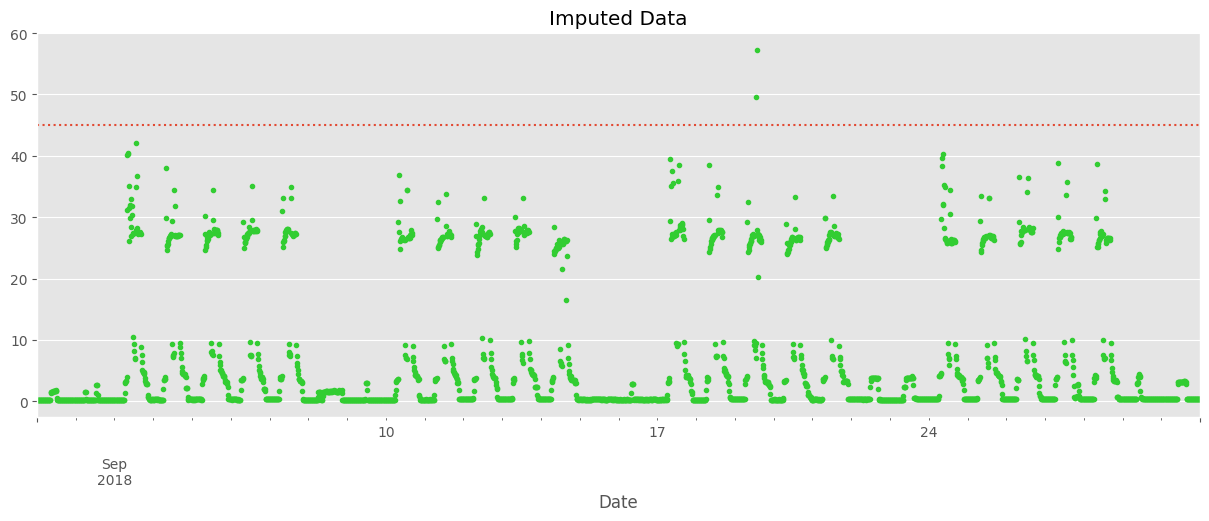

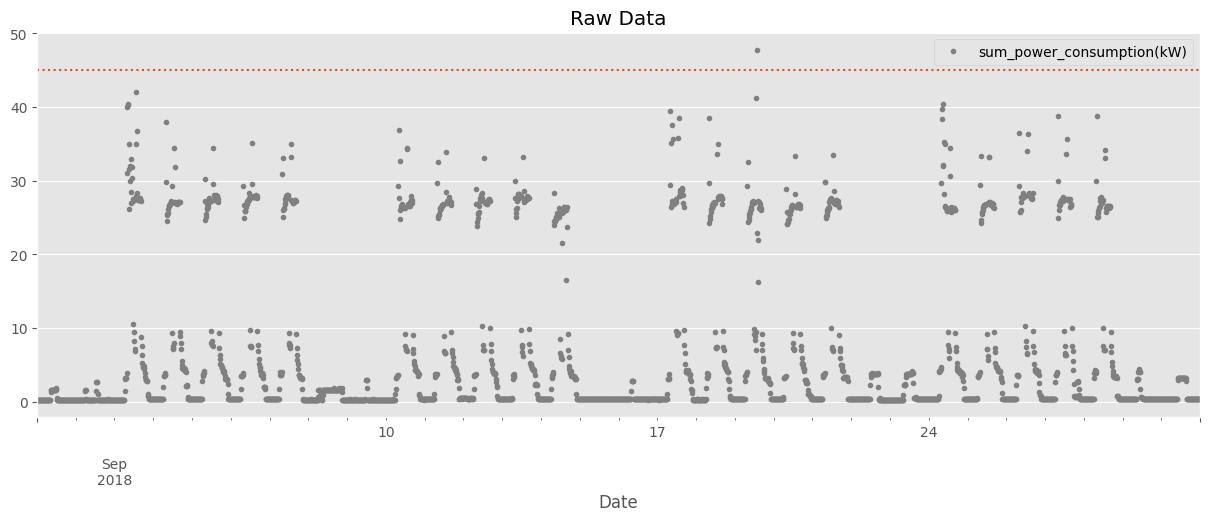

In [230]:
ax = df_temp.loc[(df_temp.index > '2018-09-01') & (df_temp.index < f'2018-10-01')]['sum_power_consumption(kW)']\
  .plot(figsize=(15, 5), style='.', color='limegreen')
ax.set_title('Imputed Data')
plt.axhline(y=45, linestyle=':')
plt.show()

df_x = ee.set_date_as_index(ee.process_data(df))

ax = df_x\
  .loc[(df_x.index > '2018-09-01') & (df_x.index < '2018-10-01')][['sum_power_consumption(kW)']]\
  .plot(figsize=(15, 5), style='.', color='grey')
ax.set_title('Raw Data')
plt.axhline(y=45, linestyle=':')
plt.show()

---